In [1]:
## requirements
# conda install --file env/byoml_tensorflow.environment.yml
# conda activate byoml_tensorflow 
# pip install -r env/byoml_tensorflow.requirements.txt

In [2]:
MODEL_NAME='retries-example'
WINDOW=12
TEST_DATA_SIZE = 24

## Retries example based on a TensorFlow model

In this notebook we show how you can create and upload a TensorFlow model to Waylay. We will expect you to save your model using the [SavedModel format](https://www.tensorflow.org/guide/saved_model).
When a model is uploaded to Waylay, it takes a moment to compile the model. After compilation, the model will be available for use. If a request ('get' or 'predict') is done before the model is compiled, a 409 Error will be returned. Python SDK has a standard Retry policy, but this can be configured by the user as they wish. If logging is turned on, more info on each retry will be logged.

First let's import a dataset:

In [3]:
import seaborn as sns
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)

passengers                                                       
month        Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
year                                                                   
1949         112  118  132  129  121  135  148  148  136  119  104  118
1950         115  126  141  135  125  149  170  170  158  133  114  140
1951         145  150  178  163  172  178  199  199  184  162  146  166
1952         171  180  193  181  183  218  230  242  209  191  172  194
1953         196  196  236  235  229  243  264  272  237  211  180  201
1954         204  188  235  227  234  264  302  293  259  229  203  229
1955         242  233  267  269  270  315  364  347  312  274  237  278
1956         284  277  317  313  318  374  413  405  355  306  271  306
1957         315  301  356  348  355  422  465  467  404  347  305  336
1958         340  318  362  348  363  435  491  505  404  359  310  337
1959         360  342  406  396  420  472  548  559  463  407  362  405
1960         417  391  419  461  472  535  622  606  508  461  390  432

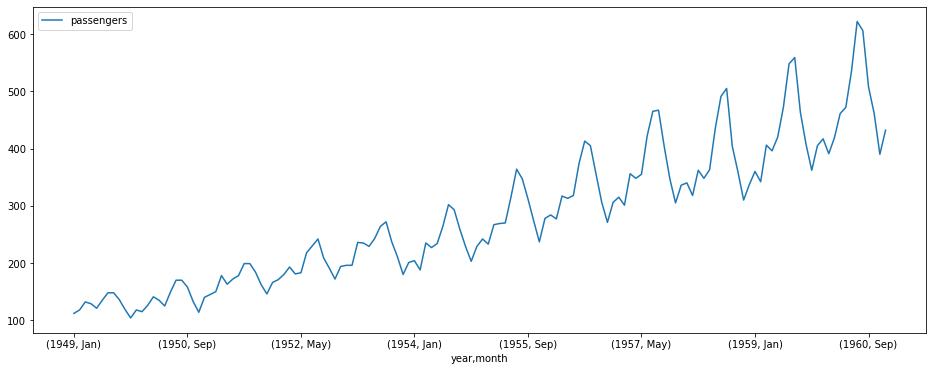

In [4]:
df = sns.load_dataset('flights')
df = df.set_index(['year', 'month'])
df.plot(figsize=(16,6))
df.unstack('month')

In [5]:
import tensorflow as tf
import numpy as np

In [6]:


# features are a sliding window over the last 12 months, predicting the following month
def features_and_labels(input_df, window=WINDOW):
    feat_columns = [ f'+{i}M' for i in range(window) ]
    label_columns = [f'+{window}M']
    index = input_df.index[:len(input_df.index) - window]
    
    ds = tf.data.Dataset.from_tensor_slices(input_df['passengers'].values)
    feat_ds = ds.window(window, shift=1, drop_remainder=True).take(len(index))
    
    df_feat = pd.DataFrame(
        data=(list(w.as_numpy_iterator()) for w in feat_ds), 
        index=index, 
        columns=feat_columns
    )

    df_labels = pd.DataFrame(
        data=input_df.iloc[window:,0].values, 
        index=index, 
        columns=label_columns
    )
    
    return pd.concat([df_feat, df_labels], axis=1, keys=['features','labels'])

df_train = features_and_labels(df.iloc[:-TEST_DATA_SIZE])
display(df_train)
df_test = features_and_labels(df.iloc[-TEST_DATA_SIZE-WINDOW:])

features                                                         \
                +0M  +1M  +2M  +3M  +4M  +5M  +6M  +7M  +8M  +9M +10M +11M   
year month                                                                   
1949 Jan        112  118  132  129  121  135  148  148  136  119  104  118   
     Feb        118  132  129  121  135  148  148  136  119  104  118  115   
     Mar        132  129  121  135  148  148  136  119  104  118  115  126   
     Apr        129  121  135  148  148  136  119  104  118  115  126  141   
     May        121  135  148  148  136  119  104  118  115  126  141  135   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1957 Aug        467  404  347  305  336  340  318  362  348  363  435  491   
     Sep        404  347  305  336  340  318  362  348  363  435  491  505   
     Oct        347  305  336  340  318  362  348  363  435  491  505  404   
     Nov        305  336  340  318  362  348  363  435  491  505  404  359   
     Dec        336  340  318  362  348  363  435  491  505  404  359  310   

           labels  
             +12M  
year month         
1949 Jan      115  
     Feb      126  
     Mar      141  
     Apr      135  
     May      125  
...           ...  
1957 Aug      505  
     Sep      404  
     Oct      359  
     Nov      310  
     Dec      337  

[108 rows x 13 columns]

In [7]:
X_train = tf.convert_to_tensor(df_train.xs('features',axis=1).values)
y_train = tf.convert_to_tensor(df_train.xs('labels',axis=1).values)
X_test = tf.convert_to_tensor(df_test.xs('features',axis=1).values)
y_test = tf.convert_to_tensor(df_test.xs('labels',axis=1).values)

Now we can create the model, a simple one:

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],), name="previous_month"))
model.add(tf.keras.layers.Reshape((X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam' , loss='mse')

In [9]:
history = model.fit(X_train, y_train,
                    batch_size=4,
                    epochs=10,
                    verbose=1)

Train on 108 samples
Epoch 1/10
108/108 [==============================] - 1s 9ms/sample - loss: 74630.1434
Epoch 2/10
108/108 [==============================] - 0s 899us/sample - loss: 73606.1029
Epoch 3/10
108/108 [==============================] - 0s 911us/sample - loss: 71911.3507
Epoch 4/10
108/108 [==============================] - 0s 922us/sample - loss: 69571.9395
Epoch 5/10
108/108 [==============================] - 0s 901us/sample - loss: 67789.5957
Epoch 6/10
108/108 [==============================] - 0s 1ms/sample - loss: 65990.7030
Epoch 7/10
108/108 [==============================] - 0s 934us/sample - loss: 64589.8505
Epoch 8/10
108/108 [==============================] - 0s 904us/sample - loss: 63403.0373
Epoch 9/10
108/108 [==============================] - 0s 906us/sample - loss: 62246.8359
Epoch 10/10
108/108 [==============================] - 0s 901us/sample - loss: 61161.0256


Let's validate if the model learned something:

<AxesSubplot:xlabel='year,month'>

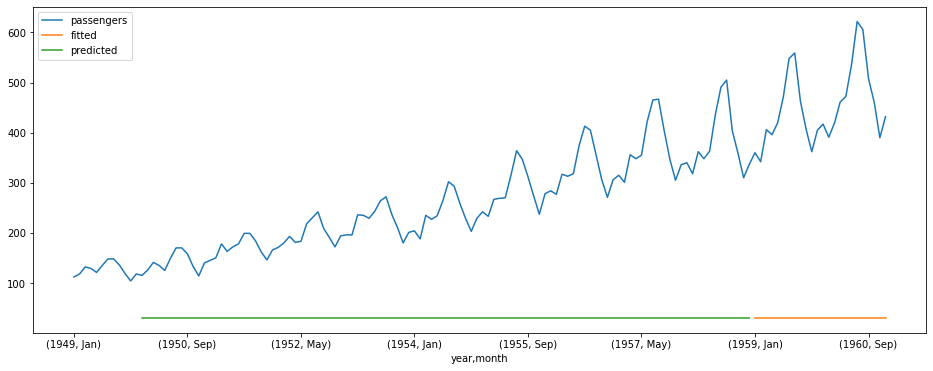

In [10]:
df_pred = df.copy()
df_pred['fitted'] = np.NaN
df_pred['predicted'] = np.NaN
df_pred.iloc[-TEST_DATA_SIZE:,1] = model.predict(X_test)
df_pred.iloc[WINDOW:-TEST_DATA_SIZE,2] =  model.predict(X_train)

df_pred.plot(figsize=(16,6))

## Save the model and upload 

We will save the model in SavedModel format and then upload it to Waylay. 

In [11]:
from waylay import WaylayClient, RestResponseError
import tempfile

waylay = WaylayClient.from_profile()

In [12]:
# clean up existing model
import time
try:
    waylay.byoml.model.remove(MODEL_NAME)
    display(f'Removed: {MODEL_NAME}')
    time.sleep(10)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'http://localhost:9050/models/retries-example')"

In [14]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example'
)

result

INFO:tensorflow:Assets written to: /var/folders/07/zn347xhn33z8m79l8xtz1hn80000gp/T/tmpy2ieo1vl/assets


{'message': 'Model successfully uploaded'}

After upload, it can take a few seconds before the model is available for execution.
You can expect to receive an error 
> 409 Model not ready yet

when executing the model too early. We will demonstrate the use of the retry configurations by setting the max delay to 1 second. This will result in a 409 Error. We can also change the retry attempts to an integer lower than 1, which will result in only 1 attempt. Using the default retry parameters, the requests in this demo should work. Both parameters can be given as arguments too, but only the argument with the lowest value will be executed.

In [15]:
try:
    result = waylay.byoml.model.get(MODEL_NAME, retry_max_delay = 1)
    display(result)
except Exception as e:
    display(e)

{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-06-21T10:00:46.980000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.1',
 'name': 'retries-example',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2021-06-21T10:00:46.980000+00:00',
 'version': '1'}

In [16]:
try:
    result = waylay.byoml.model.get(MODEL_NAME, retry_max_delay = 0, retry_attempts=1000)
    display(result)
except Exception as e:
    display(get_exception)


{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-06-21T10:00:46.980000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.1',
 'name': 'retries-example',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2021-06-21T10:00:46.980000+00:00',
 'version': '1'}

In [17]:
result = waylay.byoml.model.get(MODEL_NAME)
result

{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-06-21T10:00:46.980000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.1',
 'name': 'retries-example',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2021-06-21T10:00:46.980000+00:00',
 'version': '1'}

We can remove the model and demonstrate the same with the predict request.

In [19]:
try:
    waylay.byoml.model.remove(MODEL_NAME)
    time.sleep(30)
except:
    display('ignored error on remove')

result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example',
    timeout=300
)

result

'ignored error on remove'

INFO:tensorflow:Assets written to: /var/folders/07/zn347xhn33z8m79l8xtz1hn80000gp/T/tmpm530ucio/assets


{'message': 'Model successfully uploaded'}

In [20]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy(), retry_attempts = -1.5)
    display(len(predictions))
except Exception as e:
    display(get_exception)
    


24

In [21]:
predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
len(predictions)

24

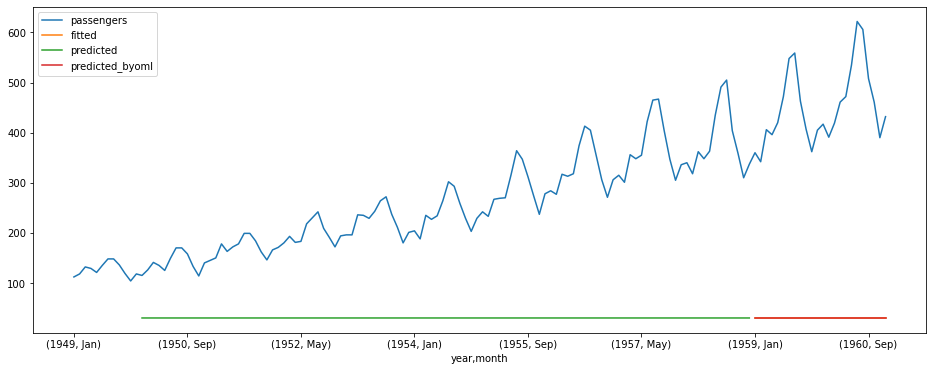

In [22]:
df_pred['predicted_byoml'] = np.NaN
df_pred.iloc[-TEST_DATA_SIZE:,3] = predictions

df_pred.plot(figsize=(16,6))
pass

<AxesSubplot:xlabel='year,month'>

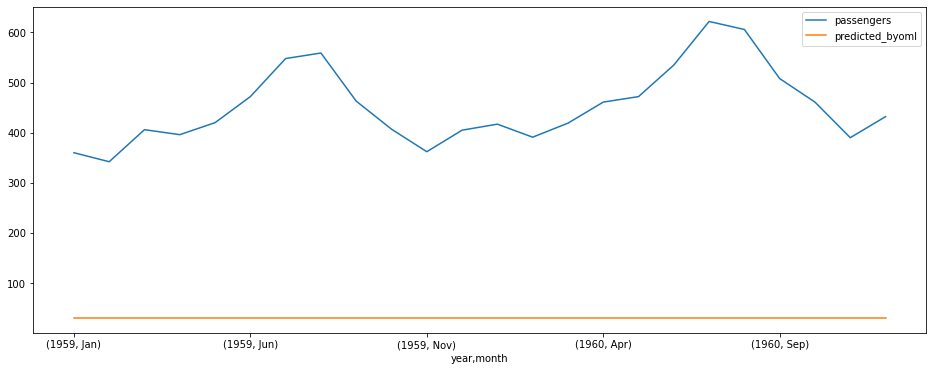

In [23]:
df_pred[['passengers','predicted_byoml']].iloc[-TEST_DATA_SIZE:].plot(figsize=(16,6))

In [24]:
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model successfully deleted'}

There are many other ways to create a SavedModel, for example using [Estimators](https://www.tensorflow.org/guide/estimator#savedmodels_from_estimators) or using a custom [Module](https://www.tensorflow.org/guide/saved_model#saving_a_custom_model), all follow the same flow to upload the model to Waylay. Just pass the directory where you saved your model to the SDK and we will do the rest.